In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from dataset.dataset import SaladsDataset
from utils.pm_utils import discover_dk_process
from utils.graph_utils import prepare_process_model_for_gnn
from utils.Config import Config
import json
import pickle as pkl
import pm4py
from modules.GraphEncoder import GraphEncoder
import torch

In [2]:
with open("config.json", "r") as f:
    cfg_json = json.load(f)
    cfg = Config(**cfg_json)

In [3]:
with open(cfg.data_path, "rb") as f:
    dataset = pkl.load(f)
salads_dataset = SaladsDataset(dataset['target'], dataset['stochastic'])
train_dataset, test_dataset = train_test_split(salads_dataset, train_size=cfg.train_percent, shuffle=True,
                                               random_state=cfg.seed)

In [4]:
model, initial, final = discover_dk_process(train_dataset, cfg)

In [7]:
model.transitions

{(1bde63a3-820a-4ed8-bd49-1bef3b9a18c0, 'add_dressing'),
 (2c370749-8be1-4022-aa51-85b2303cc292, 'place_lettuce_into_bowl'),
 (3575c894-df84-4a44-a00f-ed2cbe7ec6ab, 'place_cucumber_into_bowl'),
 (3a8a3d53-7745-4a27-b837-8e2859f31c04, 'action_start'),
 (4e76b378-6118-48b9-9d26-2359add8662a, 'mix_dressing'),
 (66344706-9dab-4c3c-a458-2fe1d441cb27, 'add_oil'),
 (6b0e783e-efef-4447-a995-e6423205000d, 'cut_lettuce'),
 (70a1869d-7873-4e9f-9b76-b324760be969, 'add_vinegar'),
 (7c65bd34-5dab-4186-b71a-bb2833689f97, 'peel_cucumber'),
 (95a5c667-e339-4b34-8389-3c3f63039007, 'add_salt'),
 (9cd8b2a5-2733-458a-82d7-e893d7f88987, 'place_cheese_into_bowl'),
 (a3c10438-f3a7-4d27-b4bb-d333ab95b006, 'cut_tomato'),
 (a50d8c62-b588-4e9b-8ce8-3437c1339edc, 'mix_ingredients'),
 (ae4c1566-a9ef-46d9-858e-441f24077ab5, 'place_tomato_into_bowl'),
 (affd7c3f-9e8a-4de4-8474-52dba58f060c, 'cut_cucumber'),
 (decf771e-fc7a-468c-805d-cca6f0b5f0bc, 'cut_cheese'),
 (ed584d5b-a95e-46f1-9bf4-49c4a6ec96e5, 'action_end'),
 

In [25]:
activity_nodes = {t.name for t in model.transitions if t.label is not None}

In [ ]:
pm4py.objects.petri_net.obj.PetriNet.Transition

In [5]:
model_nx = pm4py.convert_petri_net_to_networkx(model, initial, final)

In [29]:
for node, attr in model_nx.nodes(data=True):
    print(attr['attr'])

{'name': 'p_52', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_31', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_74', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_55', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_69', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_25', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_68', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_73', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_47', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_51', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_16', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_6', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_18', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}
{'name': 'p_23', 'is_in_im': False, 'is_in_fm': False, 'type': 'p

In [15]:
from torch_geometric.data import HeteroData

hetero_data = HeteroData()
place_nodes = [node for node, attrs in model_nx.nodes(data=True) if attrs['attr']['type'] == 'place']
transition_nodes = [node for node, attrs in model_nx.nodes(data=True) if attrs['attr']['type'] == 'transition']

In [16]:
len(place_nodes) + len(transition_nodes) - len(model_nx.nodes)

0

In [63]:
node_index = 0
node_to_index_map = {}
for node in model_nx.nodes(data=True):
    if node[0] in activity_nodes:
        node[1]['x'] = [node_index]
        node_to_index_map[node[0]] = node_index
        node_index += 1
for node in model_nx.nodes(data=True):
    if node[0] not in activity_nodes:
        node[1]['x'] = [node_index]
        node_to_index_map[node[0]] = node_index
        node_index += 1

In [64]:
sorted_nodes = sorted(model_nx.nodes(data=True), key=lambda node: node[1]['x'])
transition_features = torch.tensor([node[1]['x'] for node in sorted_nodes if node[1]['attr']['type'] == 'transition'])
place_features = torch.tensor([node[1]['x'] for node in sorted_nodes if node[1]['attr']['type'] == 'place'])

In [65]:
hetero_data['transitions'].x = transition_features 
hetero_data['places'].x = place_features

In [69]:
edges_t_to_p = [(node_to_index_map[u], node_to_index_map[v]) for u, v in model_nx.edges() if model_nx.nodes[u]['attr']['type'] == 'transition']
edges_p_to_t = [(node_to_index_map[u], node_to_index_map[v]) for u, v in model_nx.edges() if model_nx.nodes[u]['attr']['type'] == 'place']

In [70]:
len(edges_t_to_p) + len(edges_p_to_t) - len(model_nx.edges)

0

In [71]:
hetero_data['transition', 'transition_to_place', 'place'].edge_index = torch.tensor(edges_t_to_p).t() 
hetero_data['place', 'place_to_transition', 'transition'].edge_index = torch.tensor(edges_p_to_t).t()

In [24]:
from pm4py.sim import play_out

thingy = play_out(model, initial, final, parameters={"noTraces": 10000, "maxTraceLength": 8000})  # apply in basic_playout

In [25]:
max([len(x) for x in thingy])

130

In [5]:
gnn_data = prepare_process_model_for_gnn(model, initial, final, cfg)

TypeError: iteration over a 0-d tensor

In [6]:
model_nx = pm4py.convert_petri_net_to_networkx(model, initial, final)

In [10]:
from utils.graph_utils import get_feature_collections

get_feature_collections(model_nx, None)[0]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

In [14]:
model_nx.number_of_nodes()

151

In [10]:
graph_encoder = GraphEncoder(gnn_data.num_nodes, embedding_dim=512, hidden_dim=256, output_dim=128)

In [11]:
encoded_nx = graph_encoder(gnn_data)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [10]:
encoded_nx.shape

torch.Size([151, 16])

In [19]:
nx_model = pm4py.convert_petri_net_to_networkx(model, initial, final)

In [20]:
{n[1]['attr']['type'] for n in nx_model.nodes(data=True)}

{'place', 'transition'}

In [21]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

node_names = np.array([n[0] for n in nx_model.nodes(data=True)]).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(node_names)

OneHotEncoder(sparse_output=False)

In [22]:
victim = next(iter(nx_model.nodes(data=True)))

In [23]:
encoder.transform(np.array(victim[0]).reshape(-1, 1))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

In [24]:
victim[1]['attr']

{'name': 'p_80', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}

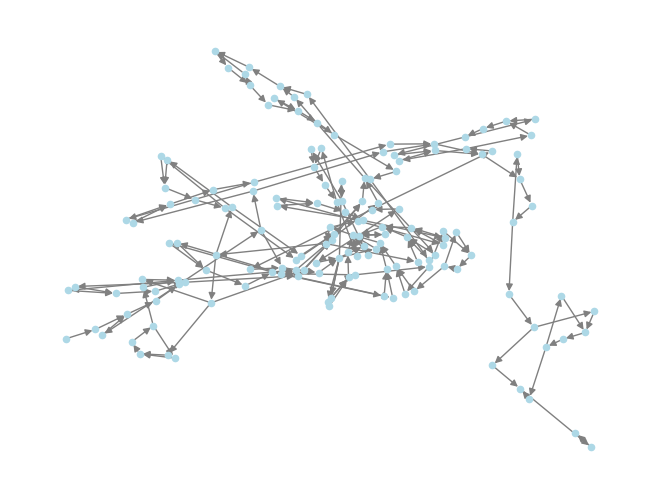

In [25]:
import networkx as nx

nx.draw(nx_model, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=15)

In [26]:
# from torch_geometric.utils import from_networkx
# 
# data = from_networkx(nx_model)

In [27]:
top_nodes = set(n for n, a in nx_model.nodes(data=True) if a['attr']['type'] == 'place')
bottom_nodes = set(nx_model) - top_nodes

In [28]:
degree_centrality = nx.bipartite.degree_centrality(nx_model, top_nodes)

In [29]:
degree_centrality[next(iter(top_nodes))]

0.03260869565217391

In [30]:
from node2vec import Node2Vec

In [31]:
n2v = Node2Vec(nx_model, dimensions=64, walk_length=30, num_walks=200, p=1, q=1, workers=1, seed=42)

Computing transition probabilities:   0%|          | 0/151 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:01<00:00, 110.80it/s]


In [32]:
n2v_model = n2v.fit(window=10, min_count=1, batch_words=4)

In [33]:
[n2v_model.wv[n] for n in nx_model.nodes]

[array([ 3.7011698e-01,  5.7133816e-02,  3.4895957e-01, -5.2659670e-03,
        -1.9428563e-01,  4.3434046e-02, -1.5050629e-01, -4.5703417e-01,
        -4.7293109e-01, -8.9139885e-01,  2.4824530e-01, -6.2886655e-01,
        -7.6626438e-01, -3.5762516e-01,  5.4326355e-01,  9.1924602e-01,
        -3.9616132e-01, -4.5972462e-03, -7.5233720e-02,  7.2559601e-01,
         3.8790980e-01,  4.0342188e-01,  1.0084648e+00,  6.6389353e-04,
         2.4089055e-01,  4.3695948e-01,  2.6335627e-01, -2.0317388e-01,
         1.0266416e+00,  3.6672130e-01, -1.1999077e-01, -1.2100697e-01,
        -1.9374542e-01, -8.2848988e-02, -5.1564431e-01, -1.8621747e-01,
         2.5314131e-01, -1.8430057e-01,  2.7590045e-01, -4.2640054e-01,
        -8.5960701e-02,  1.1239712e-01,  2.6311406e-01, -7.6982957e-01,
         3.6829519e-01, -2.2264816e-02,  1.7114365e-01, -7.7891904e-01,
        -2.2312142e-01,  5.2498341e-01,  4.1138691e-01,  1.1763153e-01,
         9.5085305e-01,  6.3620812e-01,  4.7866669e-01, -1.93887